In [1]:
import sys
sys.path.append("..")

In [2]:
from functools import partial

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist

from modules.config import read_config
from modules.datageneration import load_data, data_functions

from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import tyxe
pyro.set_rng_seed(42)

In [3]:
x1 = torch.rand(50, 1) * 0.3 - 1
x2 = torch.rand(50, 1) * 0.5 + 0.5
x = torch.cat([x1, x2])
y = x.mul(4).add(0.8).cos() + 0.1 * torch.randn_like(x)

x_test = torch.linspace(-2, 2, 401).unsqueeze(-1)
y_test = x_test.mul(4).add(0.8).cos()

In [4]:
x.shape, y.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [5]:
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=len(x))

In [6]:
x1, y1 = next(iter(loader))

In [7]:
y1

tensor([[-0.4760],
        [-0.4482],
        [-0.8140],
        [-0.5051],
        [-0.9849],
        [-0.7309],
        [-0.9503],
        [-0.6621],
        [-0.4532],
        [-0.8675],
        [-0.4863],
        [-0.8241],
        [-0.6516],
        [-0.7999],
        [-0.6392],
        [-0.8357],
        [-0.4642],
        [-0.7987],
        [-1.0049],
        [-0.7156],
        [-0.8619],
        [-0.9615],
        [-0.8546],
        [-0.6232],
        [-0.8882],
        [-0.9311],
        [-0.8595],
        [-0.9426],
        [-0.8837],
        [-0.9480],
        [-0.5158],
        [-1.0487],
        [-0.5499],
        [-0.6377],
        [-0.8750],
        [-0.5543],
        [-0.8411],
        [-0.5240],
        [-0.8139],
        [-0.8567],
        [-0.8006],
        [-0.8258],
        [-0.7696],
        [-0.4100],
        [-0.6089],
        [-0.9659],
        [-0.7744],
        [-0.8534],
        [-0.6358],
        [-1.0056],
        [-1.0188],
        [-0.9528],
        [-0.

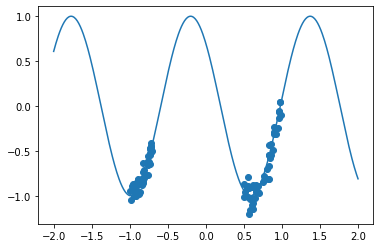

In [8]:

plt.scatter(x.squeeze(), y)
plt.plot(x_test.squeeze(), y_test)

In [9]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50, 1))
optim = torch.optim.Adam(net.parameters(), 1e-4)
for _ in range(10000):
    optim.zero_grad()
    net(x).sub(y).pow(2).mean().backward()
    optim.step()

(-2.0, 2.0)

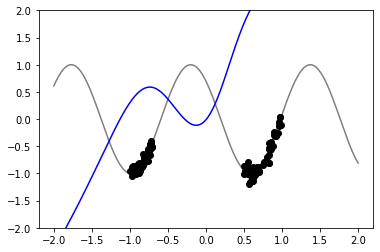

In [21]:
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black", alpha=0.5)
plt.plot(x_test, net(x_test).detach(), color="blue")
plt.ylim(-2, 2)

In [11]:
net = nn.Sequential(nn.Linear(1, 50), nn.Tanh(), nn.Linear(50,1))

In [12]:
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))

In [13]:
obs_model = tyxe.likelihoods.HomoskedasticGaussian(len(x), scale=0.1)

In [14]:
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)

In [15]:
bnn = tyxe.VariationalBNN(net, prior, obs_model, guide_builder)

In [16]:
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []
def callback(bnn, i, e):
    if i % 1000 == 0:
        print("epoch: {} | elbo: {}".format(i, e))
    elbos.append(e)
    
bnn.fit(loader, optim, 20000, callback)

epoch: 0 | elbo: 1073.00830078125
epoch: 1000 | elbo: 638.95361328125
epoch: 2000 | elbo: 451.8163757324219
epoch: 3000 | elbo: 386.37548828125
epoch: 4000 | elbo: 348.9111022949219
epoch: 5000 | elbo: 318.8196105957031
epoch: 6000 | elbo: 310.3151550292969
epoch: 7000 | elbo: 297.940185546875
epoch: 8000 | elbo: 279.4009094238281
epoch: 9000 | elbo: 263.28692626953125
epoch: 10000 | elbo: 278.6866455078125
epoch: 11000 | elbo: 260.30474853515625
epoch: 12000 | elbo: 253.2273712158203
epoch: 13000 | elbo: 244.33367919921875
epoch: 14000 | elbo: 255.7843017578125
epoch: 15000 | elbo: 240.11376953125
epoch: 16000 | elbo: 254.45590209960938
epoch: 17000 | elbo: 226.927978515625
epoch: 18000 | elbo: 247.45755004882812
epoch: 19000 | elbo: 303.9042663574219


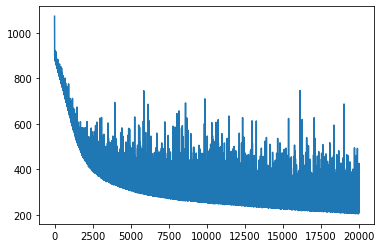

In [17]:
plt.plot(elbos)

In [18]:
m, sd = bnn.predict(x_test, num_predictions=32)

(-2.0, 2.0)

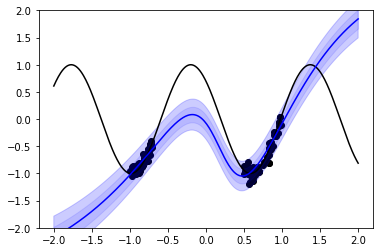

In [24]:
plt.plot(x_test, y_test, color="black")
plt.scatter(x, y, color="black")
plt.plot(x_test, m.detach(), color="blue")
for c in range(1, 3):
    plt.fill_between(x_test.squeeze(), (m - c * sd).squeeze(), (m + c * sd).squeeze(), alpha=c * 0.1, color="blue")
plt.ylim(-2, 2)

(-2.0, 2.0)

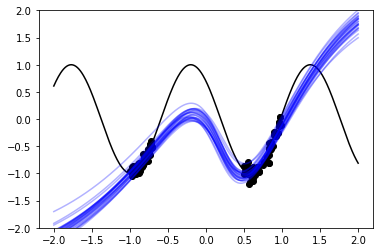

In [20]:

sampled_predictions = bnn.predict(x_test, num_predictions=25, aggregate=False)
plt.scatter(x, y, color="black")
plt.plot(x_test, y_test, color="black")
for yhat in sampled_predictions:
    plt.plot(x_test, yhat, color="blue", alpha=0.3)
plt.ylim(-2, 2)